# COVID 19 classification


Version 3, November 2020, working on fastai v2.
Main changes: 
- Training using hmhospitales dataset and rsna pneumonia challenge.

In [97]:
 import os
 os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
 os.environ['CUDA_VISIBLE_DEVICES']='0'


In [98]:
import gc


In [99]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [100]:
from fastai.vision.all import *
from fastai.metrics import error_rate
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import fastai; fastai.__version__

from sklearn.model_selection import train_test_split



In [101]:
torch.cuda.is_available()

True

In [102]:
#!pip list


If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [103]:
bs = 16
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
size_1 = 256
size_2 = 512

## data

In [104]:
path ='/home/robert/data/covid/'; path

'/home/robert/data/covid/'

### Load Normal and pneumonia from RSNA Pneumonia dataset 

In [141]:
def print_info(df, dataset_name):
    print(dataset_name, str(len (df)), '-> normal:', str(sum(df[1]=='normal'))\
          ,'pneumonia:',  str(sum(df[1]=='pneumonia')), 'COVID-19:', str(sum(df[1]=='COVID-19')))


In [142]:
dfTrain = pd.read_csv(path+'train_RSNA_processed.csv', header=None)
dfTrain['valid'] = 0
dfTrain[0] = 'train_RSNA/processed/' + dfTrain[0].astype(str)
print_info(dfTrain, 'RSNA')

# # adding padchest
dfTrain_padchest = pd.read_csv(path+'padchest/train_split_np.csv', header=None)
dfTrain_padchest['valid'] = 0
dfTrain_padchest[0] = 'padchest/trainNP/processed/' + dfTrain_padchest[0].astype(str)
print_info(dfTrain_padchest, 'Padchest')

dfTrain = dfTrain.append(dfTrain_padchest)
print_info(dfTrain,'total Train')
dfTrain.head()

RSNA 13308 -> normal: 7962 pneumonia: 5346 COVID-19: 0
Padchest 8435 -> normal: 5481 pneumonia: 2954 COVID-19: 0
total Train 21743 -> normal: 13443 pneumonia: 8300 COVID-19: 0


,0,1,valid
0,train_RSNA/processed/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png,normal,0
1,train_RSNA/processed/009eb222-eabc-4150-8121-d5a6d06b8ebf.png,normal,0
2,train_RSNA/processed/01027bc3-dc40-4165-a6c3-d6be2cb7ca34.png,normal,0
3,train_RSNA/processed/017c7b5b-618e-4bc9-943c-04c6a988d992.png,normal,0
4,train_RSNA/processed/019ca122-9cdf-4704-b7a9-449c8a1c263e.png,normal,0


### Load COVID for training from hmhospitales

In [143]:
dfTrainCovid = pd.read_csv(path+'hmhospitales/train_hmh_processed.csv', header=None)
dfTrainCovid['valid'] = 0
dfTrainCovid[0] = 'hmhospitales/train/processed/' + dfTrainCovid[0].astype(str)
print_info(dfTrainCovid, "HMH")

dfTrainv3 = pd.read_csv(path+'train_split_v3.csv', header=None)
dfTrainv3['valid'] = 0
dfTrainv3[0] = 'train/processed/' + dfTrainv3[0].astype(str)
dfTrainv3 = dfTrainv3.loc[dfTrainv3[1] == 'COVID-19']
print_info(dfTrainv3, "Split_v3")

# augment de training covid data 2^3
for i in range(2):
    dfTrainv3 = dfTrainv3.append(dfTrainv3)
print_info(dfTrainv3, "Split_v3 Aug")
    
dfTrainCovid = dfTrainCovid.append(dfTrainv3)

# # salutms_xnat (217 cases)
# df_salut = pd.read_csv(path+'salutms_xnat/salutms_xnat2.csv',header=None)
# df_salut[0] = 'salutms_xnat/img/processed/' + df_salut[0].astype(str)
# df_salut.loc[df_salut[1] == ('Cardiopatia') , 1] = 'normal'
# df_salut.loc[df_salut[1] == ('Fractura') , 1] = 'normal'
# df_salut = df_salut.drop(2, 1)

# df_train_salut, df_test_salut = train_test_split(df_salut, test_size=0.5)
# print("Salutms: Aug", len (df_train_salut))
# # augment de training covid data 2^3
# for i in range(3):
#     df_train_salut = df_train_salut.append(df_train_salut)
# print("Salutms: ", len (df_train_salut))
# dfTrainCovid = dfTrainCovid.append(df_train_salut)

print_info(dfTrainCovid, "Train COVID")
dfTrainCovid.head()


HMH 2030 -> normal: 0 pneumonia: 0 COVID-19: 2030
Split_v3 271 -> normal: 0 pneumonia: 0 COVID-19: 271
Split_v3 Aug 1084 -> normal: 0 pneumonia: 0 COVID-19: 1084
Train COVID 3114 -> normal: 0 pneumonia: 0 COVID-19: 3114


,0,1,valid
0,hmhospitales/train/processed/1.2.124.113532.1266916631811037527143121792217253173208.DC3.png,COVID-19,0
1,hmhospitales/train/processed/1.2.124.113532.1291042221721822374531691781477817424919248.DC3.png,COVID-19,0
2,hmhospitales/train/processed/1.2.124.113532.14215919646721317727155472551352231942291.DC3.png,COVID-19,0
3,hmhospitales/train/processed/1.2.124.113532.144481397388233672417416612413319418444233.DC3.png,COVID-19,0
4,hmhospitales/train/processed/1.2.124.113532.15417119511021296751221372221359244236113232.DC3.png,COVID-19,0


Join Normals and covids for training


In [144]:
dfTrain = dfTrain.append(dfTrainCovid)
print_info(dfTrain,'Total Train')
dfTrain.head()

Total Train 24857 -> normal: 13443 pneumonia: 8300 COVID-19: 3114


,0,1,valid
0,train_RSNA/processed/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png,normal,0
1,train_RSNA/processed/009eb222-eabc-4150-8121-d5a6d06b8ebf.png,normal,0
2,train_RSNA/processed/01027bc3-dc40-4165-a6c3-d6be2cb7ca34.png,normal,0
3,train_RSNA/processed/017c7b5b-618e-4bc9-943c-04c6a988d992.png,normal,0
4,train_RSNA/processed/019ca122-9cdf-4704-b7a9-449c8a1c263e.png,normal,0


### Validation data test set in RSNA and HMH

In [150]:
dfTest = pd.read_csv(path+'test_RSNA_processed.csv',header=None)
dfTest['valid'] = 1
dfTest[0] = 'test_RSNA/processed/' + dfTest[0].astype(str)
print_info(dfTest,'Validation RSNA')
dfTest.head()

Validation RSNA 1463 -> normal: 885 pneumonia: 578 COVID-19: 0


,0,1,valid
0,test_RSNA/processed/009482dc-3db5-48d4-8580-5c89c4f01334.png,normal,1
1,test_RSNA/processed/00a85be6-6eb0-421d-8acf-ff2dc0007e8a.png,normal,1
2,test_RSNA/processed/00f87de5-5fe0-4921-93ea-914d7e683266.png,normal,1
3,test_RSNA/processed/01f11e57-5c11-4ab0-9312-d88c3826721c.png,normal,1
4,test_RSNA/processed/029216c8-ea0d-47bb-88fd-bf611cc5d1fc.png,normal,1


In [151]:
dfTestCovid = pd.read_csv(path+'hmhospitales/test_hmh_processed.csv',header=None)
dfTestCovid['valid'] = 1
dfTestCovid[0] = 'hmhospitales/test/processed/' + dfTestCovid[0].astype(str)
print_info(dfTestCovid, 'Validation HMH ')

dfTestCovid = dfTestCovid.append(dfTest)




dfTestCovid.head()


Validation HMH  534 -> normal: 0 pneumonia: 0 COVID-19: 534


,0,1,valid
0,hmhospitales/test/processed/1.2.124.113532.161153445713587119186200205842188946159.DC3.png,COVID-19,1
1,hmhospitales/test/processed/1.2.124.113532.1721085174194116651881671414812810016636105.DC3.png,COVID-19,1
2,hmhospitales/test/processed/1.2.124.113532.2293182203380643613922724523119131287.DC3.png,COVID-19,1
3,hmhospitales/test/processed/1.2.840.113619.2.202.4.2147483647.1585896668.811080.DC3.png,COVID-19,1
4,hmhospitales/test/processed/1.2.840.113619.2.202.4.2147483647.1586039283.272517.DC3.png,COVID-19,1


In [152]:
dfTest= dfTest.append(dfTestCovid)
print_info(dfTest, 'Total Validation')

Total Validation 3460 -> normal: 1770 pneumonia: 1156 COVID-19: 534


In [153]:
df = dfTrain.append(dfTest)
df.head()

,0,1,valid
0,train_RSNA/processed/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png,normal,0
1,train_RSNA/processed/009eb222-eabc-4150-8121-d5a6d06b8ebf.png,normal,0
2,train_RSNA/processed/01027bc3-dc40-4165-a6c3-d6be2cb7ca34.png,normal,0
3,train_RSNA/processed/017c7b5b-618e-4bc9-943c-04c6a988d992.png,normal,0
4,train_RSNA/processed/019ca122-9cdf-4704-b7a9-449c8a1c263e.png,normal,0


In [17]:
# change into 2 class problem covid NOCOVID
# df.loc[df[1] == ('pneumonia' or 'normal') , 1] = NOCOVID


In [164]:
def get_dls(bs, size,df):
    tfms = [*aug_transforms(size = size, do_flip=True, flip_vert=False, max_lighting=0.1, max_zoom=1.0,\
        max_warp=0.,pad_mode='reflection', max_rotate=5),Normalize.from_stats(*imagenet_stats)]
    dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                splitter=ColSplitter(col='valid'),
                get_x=ColReader(0, pref=path),
                get_y=ColReader(1),
                item_tfms = Resize(600),
                batch_tfms =tfms)                      
    return dblock.dataloaders(df, bs=bs)

In [165]:
np.random.seed(42)

dls = get_dls(64, 224,df)

# tfms = [*aug_transforms(do_flip=True, flip_vert=False, max_lighting=0.1, max_zoom=1.05,\
#      max_warp=0.,pad_mode='reflection', max_rotate=5),Normalize.from_stats(*imagenet_stats)]
# dls = ImageDataLoaders.from_df(df=df,path=path,  convert_mode='L', valid_col='valid', batch_tfms =tfms,
#                               bs = bs, item_tfms = Resize(size = size_1, method ='squish'))

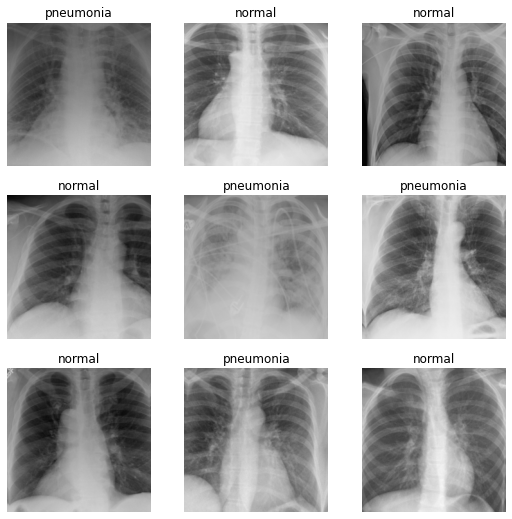

In [168]:
dls.show_batch()

In [169]:
len(dls.train_ds)

24857

In [170]:
len(dls.valid_ds)


3460

In [171]:
dls.valid_ds


(#3460) [(PILImageBW mode=L size=852x644, TensorCategory(1)),(PILImageBW mode=L size=857x724, TensorCategory(1)),(PILImageBW mode=L size=733x670, TensorCategory(1)),(PILImageBW mode=L size=796x760, TensorCategory(1)),(PILImageBW mode=L size=857x671, TensorCategory(1)),(PILImageBW mode=L size=750x734, TensorCategory(1)),(PILImageBW mode=L size=651x678, TensorCategory(1)),(PILImageBW mode=L size=810x626, TensorCategory(1)),(PILImageBW mode=L size=837x774, TensorCategory(1)),(PILImageBW mode=L size=715x729, TensorCategory(1))...]

## learner

In [172]:
torch.cuda.empty_cache()

In [173]:
dls = get_dls(128, 128,df)
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), \
                metrics= [accuracy, Precision(average='weighted'), Recall(average='weighted'), error_rate])


In [174]:
#learn.lr_find()

In [175]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,error_rate,time
0,0.656632,0.543476,0.791040,0.817401,0.791040,0.208960,01:22
1,0.493647,1.042178,0.632081,0.773449,0.632081,0.367919,01:20
2,0.397687,0.267040,0.900578,0.902452,0.900578,0.099422,01:22
3,0.330296,0.223940,0.917341,0.918436,0.917341,0.082659,01:21


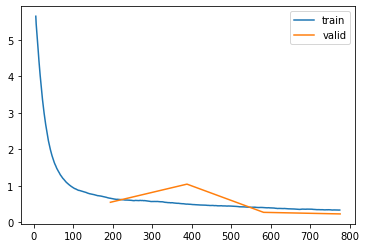

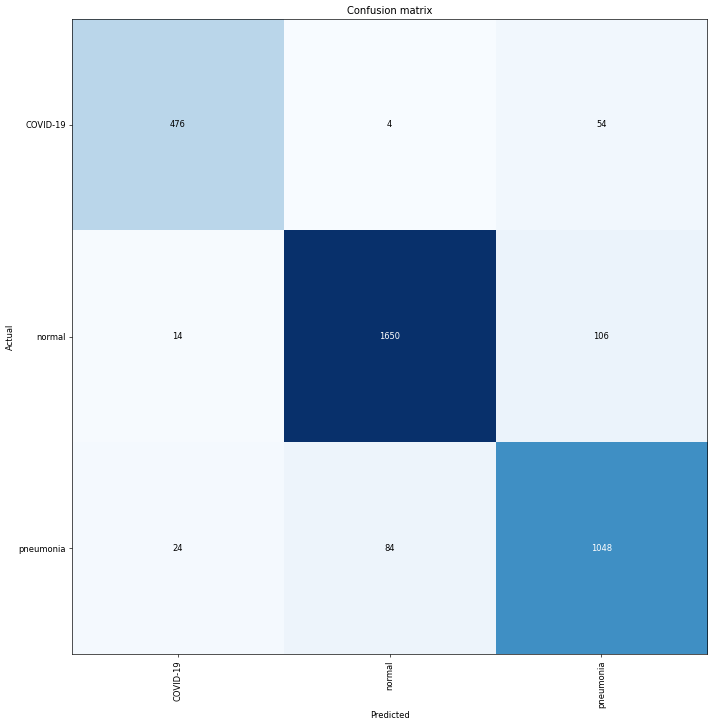

In [176]:
learn.recorder.plot_loss()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [177]:
cm = interp.confusion_matrix()
sens = np.zeros(3)
sens[0] = cm[0,0]/np.sum(cm[0,:])
sens[1] = cm[1,1]/np.sum(cm[1,:])
sens[2] = cm[2,2]/np.sum(cm[2,:])
print(sens)

[0.89138577 0.93220339 0.90657439]


In [178]:
spec = np.zeros(3)
spec[0] = cm[0,0]/np.sum(cm[:,0])
spec[1] = cm[1,1]/np.sum(cm[:,1])
spec[2] = cm[2,2]/np.sum(cm[:,2])
print(spec)

[0.92607004 0.94936709 0.86754967]


## Increase the size


In [179]:
dls = []
learn.dls = []
learn.dls = get_dls(64, 224,df)
#learn.fit_one_cycle(5, base_lr=3e-4, freeze_epochs=5)
learn.fine_tune(5, base_lr=3e-3)


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,error_rate,time
0,0.493071,0.802899,0.752023,0.776613,0.752023,0.247977,02:23


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,error_rate,time
0,0.382184,0.271466,0.893353,0.894854,0.893353,0.106647,02:22
1,0.383452,0.386746,0.857803,0.866043,0.857803,0.142197,02:22
2,0.324668,0.346052,0.870809,0.884204,0.870809,0.129191,02:23
3,0.294051,0.188154,0.934682,0.934760,0.934682,0.065318,02:24
4,0.239335,0.165551,0.938150,0.938303,0.938150,0.061850,02:22


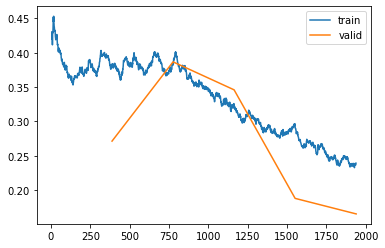

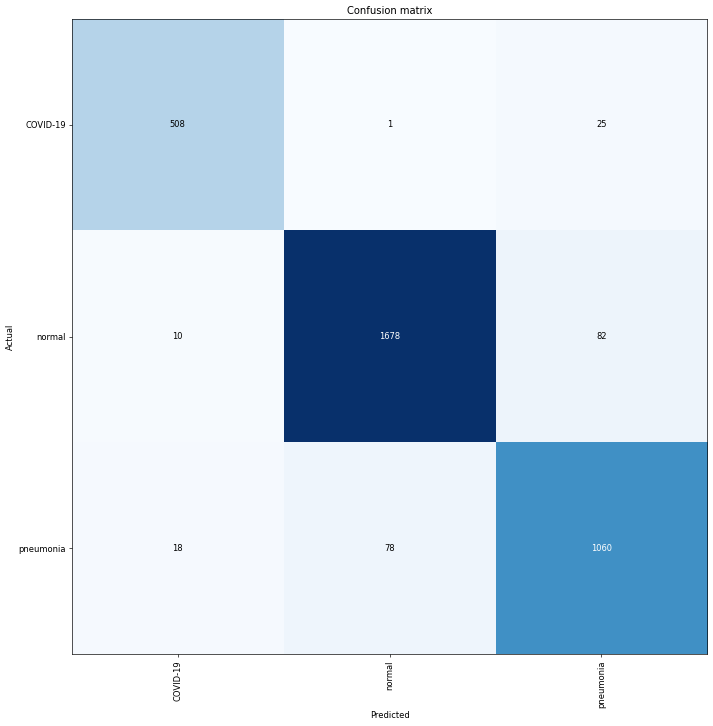

In [180]:
learn.recorder.plot_loss()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [181]:
cm = interp.confusion_matrix()
sens = np.zeros(3)
sens[0] = cm[0,0]/np.sum(cm[0,:])
sens[1] = cm[1,1]/np.sum(cm[1,:])
sens[2] = cm[2,2]/np.sum(cm[2,:])
print(sens)

[0.95131086 0.9480226  0.91695502]


In [182]:
spec = np.zeros(3)
spec[0] = cm[0,0]/np.sum(cm[:,0])
spec[1] = cm[1,1]/np.sum(cm[:,1])
spec[2] = cm[2,2]/np.sum(cm[:,2])
print(spec)

[0.94776119 0.95503699 0.90831191]


## Increase the size


In [183]:
dls = []
learn.dls = []
torch.cuda.empty_cache()
gc.collect();

In [184]:

learn.dls = get_dls(16, 512,df)
#learn.fit_one_cycle(5, base_lr=3e-4, freeze_epochs=5)
learn.fine_tune(10, base_lr=3e-3)


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,error_rate,time
0,0.574242,0.391982,0.833815,0.855694,0.833815,0.166185,10:35


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,error_rate,time
0,0.396110,0.247563,0.910983,0.912119,0.910983,0.089017,10:34
1,0.380895,0.303346,0.885549,0.893239,0.885549,0.114451,10:34
2,0.354234,1.072854,0.685838,0.820510,0.685838,0.314162,10:34
3,0.306998,0.253093,0.901445,0.903216,0.901445,0.098555,10:33
4,0.306142,0.174832,0.938439,0.938558,0.938439,0.061561,10:35
5,0.257164,0.154091,0.942775,0.944023,0.942775,0.057225,10:35
6,0.239487,0.146634,0.945376,0.945807,0.945376,0.054624,10:36
7,0.225696,0.132810,0.952601,0.952770,0.952601,0.047399,10:35
8,0.192147,0.120280,0.954046,0.953939,0.954046,0.045954,10:35
9,0.177793,0.118384,0.956358,0.956248,0.956358,0.043642,10:34


In [185]:
# lr_min,lr_steep = learn.lr_find()
# print(lr_min, lr_steep)

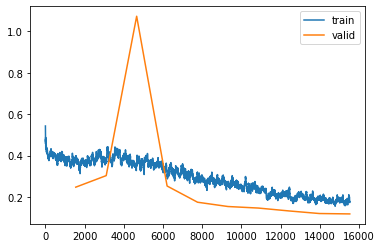

In [186]:
learn.recorder.plot_loss()

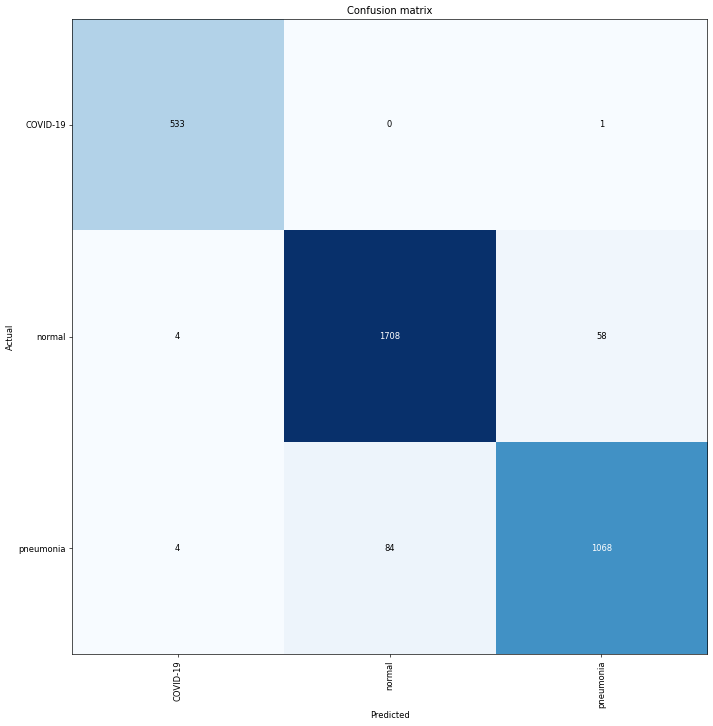

In [187]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [188]:
learn.save('stage-1_2-'+str(size_1)+'-dn50v2')

Path('models/stage-1_2-256-dn50v2.pth')

In [189]:
interp.most_confused(min_val=1)

[('pneumonia', 'normal', 84),
 ('normal', 'pneumonia', 58),
 ('normal', 'COVID-19', 4),
 ('pneumonia', 'COVID-19', 4),
 ('COVID-19', 'pneumonia', 1)]

In [190]:
cm = interp.confusion_matrix()


In [191]:
sens = np.zeros(3)
sens[0] = cm[0,0]/np.sum(cm[0,:])
sens[1] = cm[1,1]/np.sum(cm[1,:])
sens[2] = cm[2,2]/np.sum(cm[2,:])
print(sens)

[0.99812734 0.96497175 0.92387543]


In [192]:
spec = np.zeros(3)
spec[0] = cm[0,0]/np.sum(cm[:,0])
spec[1] = cm[1,1]/np.sum(cm[:,1])
spec[2] = cm[2,2]/np.sum(cm[:,2])
print(spec)

[0.98521257 0.953125   0.94764862]


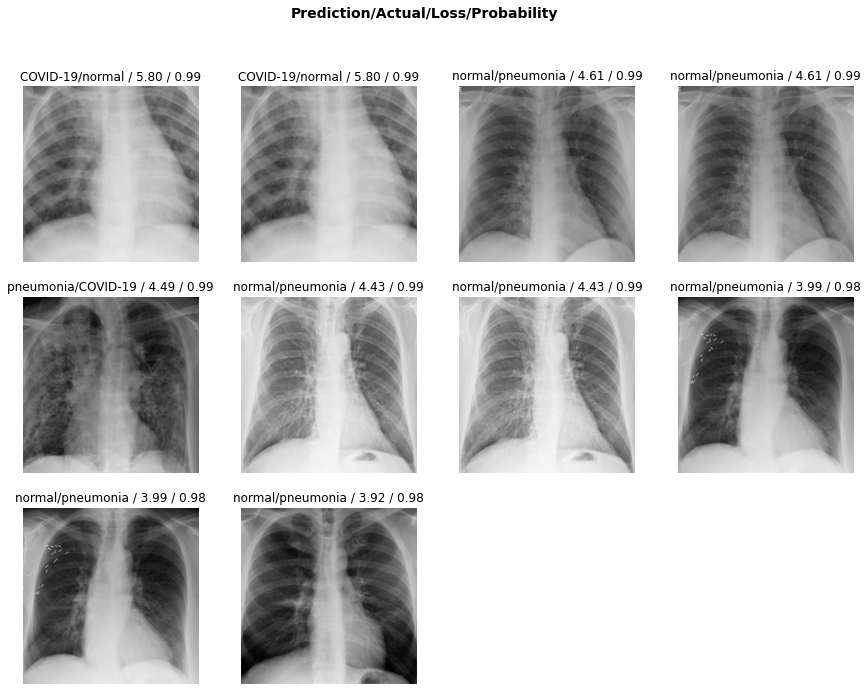

In [193]:
interp.plot_top_losses(10, figsize=(15,11), largest=True)

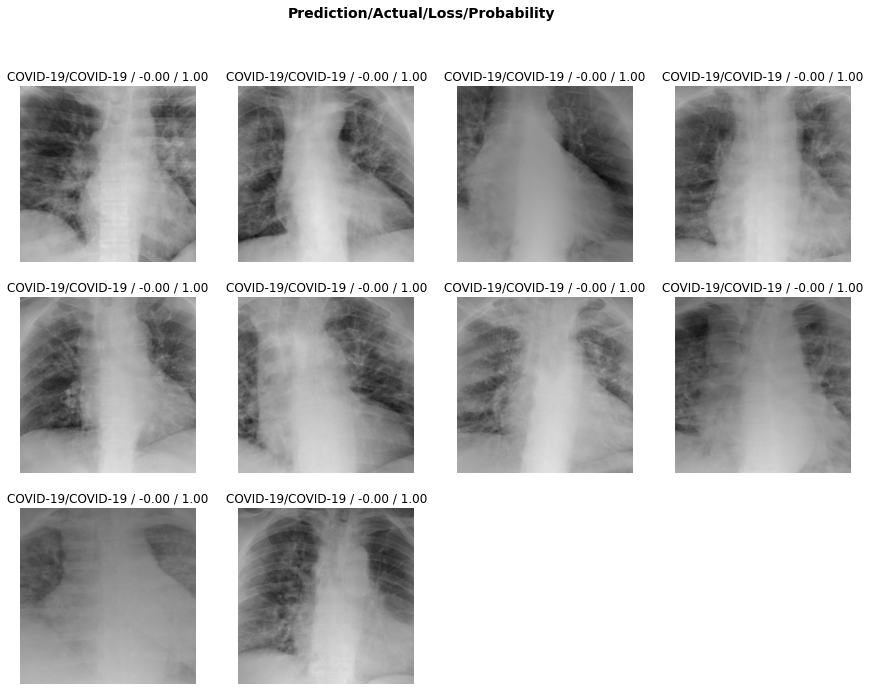

In [194]:
interp.plot_top_losses(10, figsize=(15,11), largest=False)

In [196]:
learn.export(path+'trainedAllData_resnet_ROI_'+str(size_2)+'_export_v2.pkl')

### Test on new data

In [197]:
learn = load_learner(path+'trainedAllData_resnet_ROI_'+str(size_2)+'_export_v2.pkl', cpu=False)


In [207]:
# # Data from trueta, Tic Salut, Udiat

# dfTest = pd.read_csv(path+'covid_local/covid_local_APonly.csv',header=None)
# dfTest[0] = 'covid_local/processed/' + dfTest[0].astype(str)
# print('local',len(dfTest))

# #CSMS (earlier files <20 cases)
# dfTest2 = pd.read_csv(path+'CSMS/CSMS.csv',header=None)
# dfTest2[0] = 'CSMS/processed/' + dfTest2[0].astype(str)
# dfTest2.head()
# print('CSMS',len(dfTest))

# dfTest = dfTest.append(dfTest2)

# # # padchest to include normals and pneumonia (not used for training/validation/testing)
# dfTest3 = pd.read_csv(path+'padchest/test_split_np.csv',header=None)
# dfTest3[0] = 'padchest/testNP/processed/' + dfTest3[0].astype(str)
# dfTest3.head()
# print('adchest',len(dfTest))

# dfTest = dfTest.append(dfTest3)

# #salutms (120 cases)
# dfTest4 = pd.read_csv(path+'salutms/salutms_detect.csv',header=None)
# dfTest4[0] = 'salutms/processed/' + dfTest4[0].astype(str)

# dfTest = dfTest.append(dfTest4)
# # dfTest = dfTest4

#salutms_xnat (217 cases)
# # salutms_xnat (217 cases)
df_salut = pd.read_csv(path+'salutms_xnat/salutms_xnat2.csv',header=None)
df_salut[0] = 'salutms_xnat/img/processed/' + df_salut[0].astype(str)
df_salut.loc[df_salut[1] == ('Cardiopatia') , 1] = 'normal'
df_salut.loc[df_salut[1] == ('Fractura') , 1] = 'normal'
df_salut = df_salut.drop(2, 1)

print_info(df_salut, 'xnat salut')

dfTest = df_salut
dfTest.head()


xnat salut 211 -> normal: 76 pneumonia: 0 COVID-19: 135


,0,1
0,salutms_xnat/img/processed/1.2.826.0.1.3680043.2.403.84.1200629190107882.1.345050678115-1-1-q5u8si.dcm.png,COVID-19
1,salutms_xnat/img/processed/1.2.826.0.1.3680043.2.403.84.1200402110615061.1.345050678115-1-1-1kvf88x.dcm.png,COVID-19
2,salutms_xnat/img/processed/1.2.826.0.1.3680043.2.403.84.1200401193417468.1.345050678115-1-1-5vfo49.dcm.png,COVID-19
3,salutms_xnat/img/processed/1.2.826.0.1.3680043.2.403.84.1200407145849528.1.345050678115-1-1-1p4adif.dcm.png,COVID-19
4,salutms_xnat/img/processed/1.2.826.0.1.3680043.2.403.84.1200402190834261.1.345050678115-1-1-1x5gn48.dcm.png,COVID-19


In [84]:
dl.show_batch??


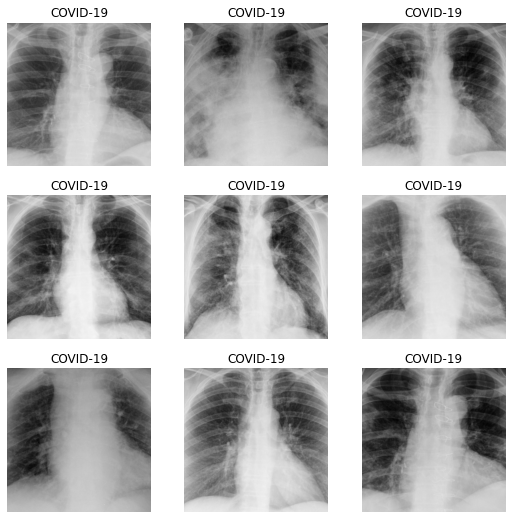

In [208]:
dl = learn.dls.test_dl(dfTest, with_labels= True, device="cuda")
dl.show_batch()

/home/robert/miniconda2/envs/fast2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


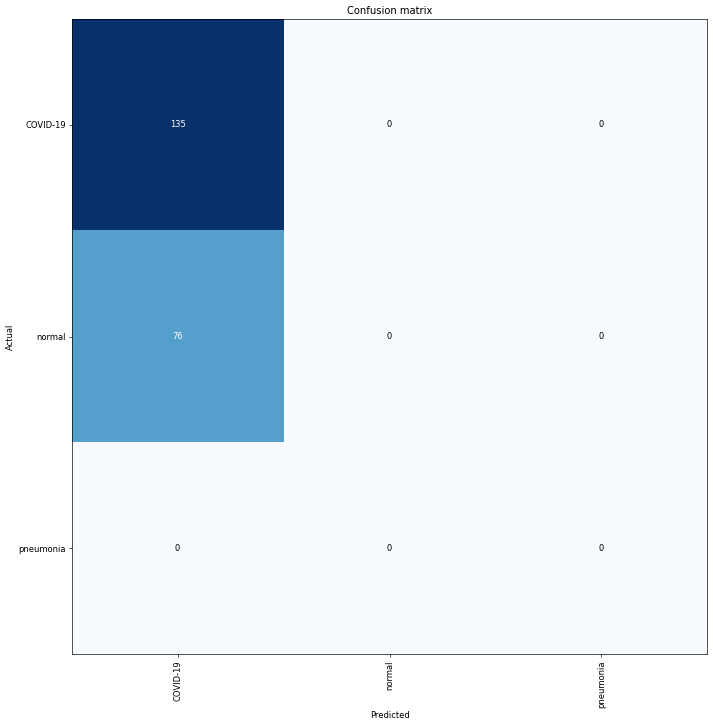

In [209]:
# preds = learn.get_preds(dl=dl)[0].numpy()
interp = ClassificationInterpretation.from_learner(learn, dl=dl)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [77]:
preds = learn.get_preds(dl=dl)
learn.validate(dl=dl)
accuracy(preds[0], preds[1])

TensorCategory(0.6351)

In [210]:
cm = interp.confusion_matrix()


In [211]:
sens = np.zeros(3)
sens[0] = cm[0,0]/np.sum(cm[0,:])
sens[1] = cm[1,1]/np.sum(cm[1,:])
sens[2] = cm[2,2]/np.sum(cm[2,:])
print('Sensitivity (COVID, NORMAL, Pneumo):' ,sens)

Sensitivity (COVID, NORMAL, Pneumo): [ 1.  0. nan]


<ipython-input-211-bb8e2ef38805>:4: RuntimeWarning: invalid value encountered in long_scalars
  sens[2] = cm[2,2]/np.sum(cm[2,:])


In [212]:
spec = np.zeros(3)
spec[0] = cm[0,0]/np.sum(cm[:,0])
spec[1] = cm[1,1]/np.sum(cm[:,1])
spec[2] = cm[2,2]/np.sum(cm[:,2])
print('Specificity (COVID, NORMAL, Pneumo): ', spec)

Specificity (COVID, NORMAL, Pneumo):  [0.63981043        nan        nan]


<ipython-input-212-330dd64e9678>:3: RuntimeWarning: invalid value encountered in long_scalars
  spec[1] = cm[1,1]/np.sum(cm[:,1])
<ipython-input-212-330dd64e9678>:4: RuntimeWarning: invalid value encountered in long_scalars
  spec[2] = cm[2,2]/np.sum(cm[:,2])


In [60]:
# old version.
# log_preds, y = learn.get_preds()

# predIdxs = np.argmax(log_preds.numpy(), axis=1)
# print(exp(log_preds))



tensor([[1.0000, 1.0004, 2.7172],
        [2.7145, 1.0013, 1.0001],
        [1.0000, 1.0000, 2.7183],
        ...,
        [1.0000, 2.7183, 1.0000],
        [1.0000, 2.7176, 1.0003],
        [2.6264, 1.0000, 1.0350]])


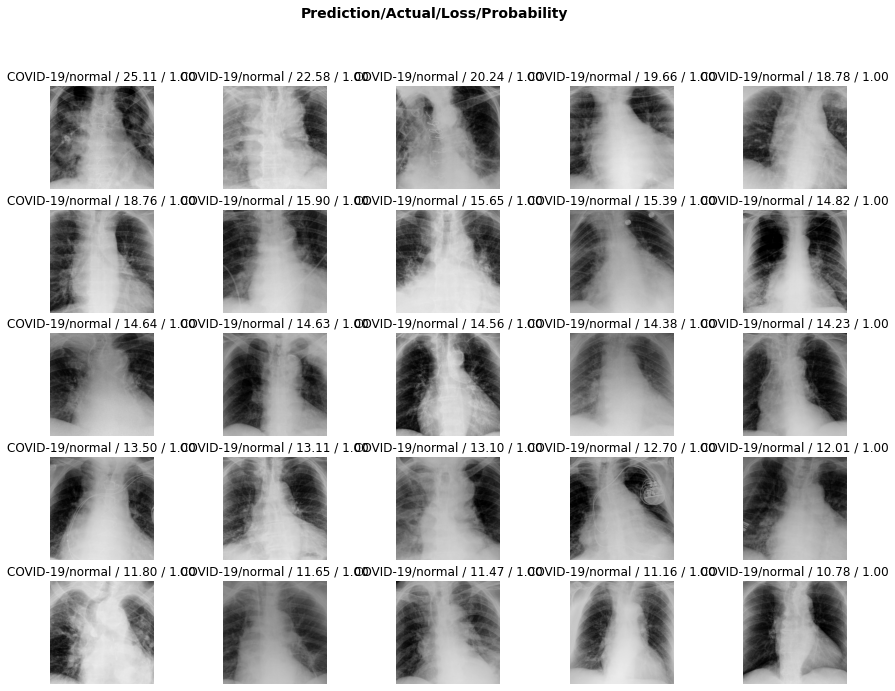

In [55]:
interp.plot_top_losses(25, figsize=(15,11), largest=True)

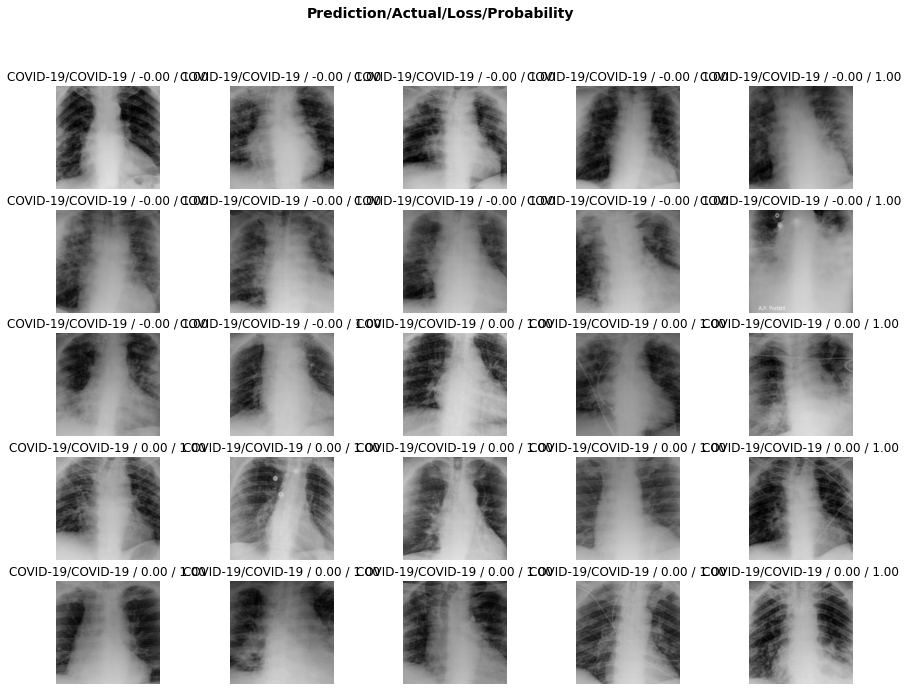

In [82]:
interp.plot_top_losses(25, figsize=(15,11), largest=False)